In [1]:
import os
import numpy as np
import subprocess
import matplotlib.pyplot as plt
from surmise.emulation import emulator
import src.plots as plots
import src.Smooth as Smooth
import src.design_points as design_points   
import shutil
import bilby
from src.AKSGP import Emulator as AKS_emu

os.environ['Smooth_PATH'] = '/Users/christalmartin/BAND_fellowship/BAND_example/bandframework/software/SmoothEmulator/'
smooth_path = os.environ['Smooth_PATH']

if not os.path.exists(smooth_path):
    print("SmoothEmulator not found. Installing...")
    Smooth.install_smooth_emulator(smooth_path)
else:
    print(f"SmoothEmulator already installed at {smooth_path}. Using it.")

os.environ['Work_PATH'] = os.getcwd()
work_path = os.environ['Work_PATH']

SmoothEmulator already installed at /Users/christalmartin/BAND_fellowship/BAND_example/bandframework/software/SmoothEmulator/. Using it.


## Parameters for Comparison Plots

In [2]:
seed = 0    #random seed for latin hypercube sampling
dmax = False #turn detmax on or off
train_size = 10
validation_size = 50

# for plotting detmax results
num_seed = 5 #number of random seeds to use
train_range = [40, 50, 60, 70, 80, 90, 100] #number of training points to use

clear = True #clear out the old files
skip_cell = True #skip the cell creation step

In [3]:
if clear:
    directories = ['smooth_emulators', 'surmise']

    for directory in directories:
        if os.path.exists(directory):
            for filename in os.listdir(directory):
                file_path = os.path.join(directory, filename)
                if os.path.isdir(file_path):
                    shutil.rmtree(file_path)  # Remove the directory and its contents
                    print(f"Deleted directory: {file_path}")
        else:
            print(f"Directory {directory} does not exist.")

Deleted directory: smooth_emulators/PbPb5020
Deleted directory: smooth_emulators/PbPb2760
Deleted directory: smooth_emulators/AuAu200


## Model and Priors

Toy model:

$R_{AA}(p_T, s_{NN})_{A,B,C,D,E} = \frac{1}{2\pi} \left(A + B e^{-0.5(p_T - C)^2} + \ln\left( Dp_T + (\text{cent}*s_{NN})^E \right)\right)$ and  $\text{cent} = 0.05$ for central collisions 

In [4]:
#parameter space for theta = [A, B, C, ...]
priors = {
    'A': bilby.core.prior.Uniform(minimum=0.5, maximum=3.0), 
    'B': bilby.core.prior.Uniform(minimum=1.0, maximum=1.8), 
    'C': bilby.core.prior.Uniform(minimum=-1.6, maximum=0.0),
    'D': bilby.core.prior.Uniform(minimum=0.0, maximum=0.2),
    'E': bilby.core.prior.Uniform(minimum=-1.5, maximum=0.0)
}

#####################

#ToyModel for R_AA
def R_AA(pT, params, cent, sNN):
    A, B, C, D, E = params  
    X = D * pT + (cent * sNN)**E
    if np.all(X > 0):
            return 1 / (2 * np.pi) * (A + B * np.exp(-((pT - C) ** 2) / 2) + np.log(X))
    else:
        print('Warning: Negative R_AA value')
        return -np.inf

######################


pT = {}

pT['AuAu200'] = [9.75, 11.0, 13.0, 15.0, 17.0, 19.0]
pT['PbPb2760' ] = [10.8, 12.3, 14.1, 16.2, 18.6, 21.4, 24.4, 28.1, 33.9, 42.6, 53.6, 67.5, 85.]
pT['PbPb5020'] = [13.2, 16.8, 21.6, 26.4, 32., 38.4, 44.8, 54.4, 67.2, 80., 95.]

parameter_names = list(priors.keys())
dim = len(parameter_names) 
train_points, validation_points = design_points.load_data(train_size, validation_size, priors, seed, dmax)


## Toy Model Predictions

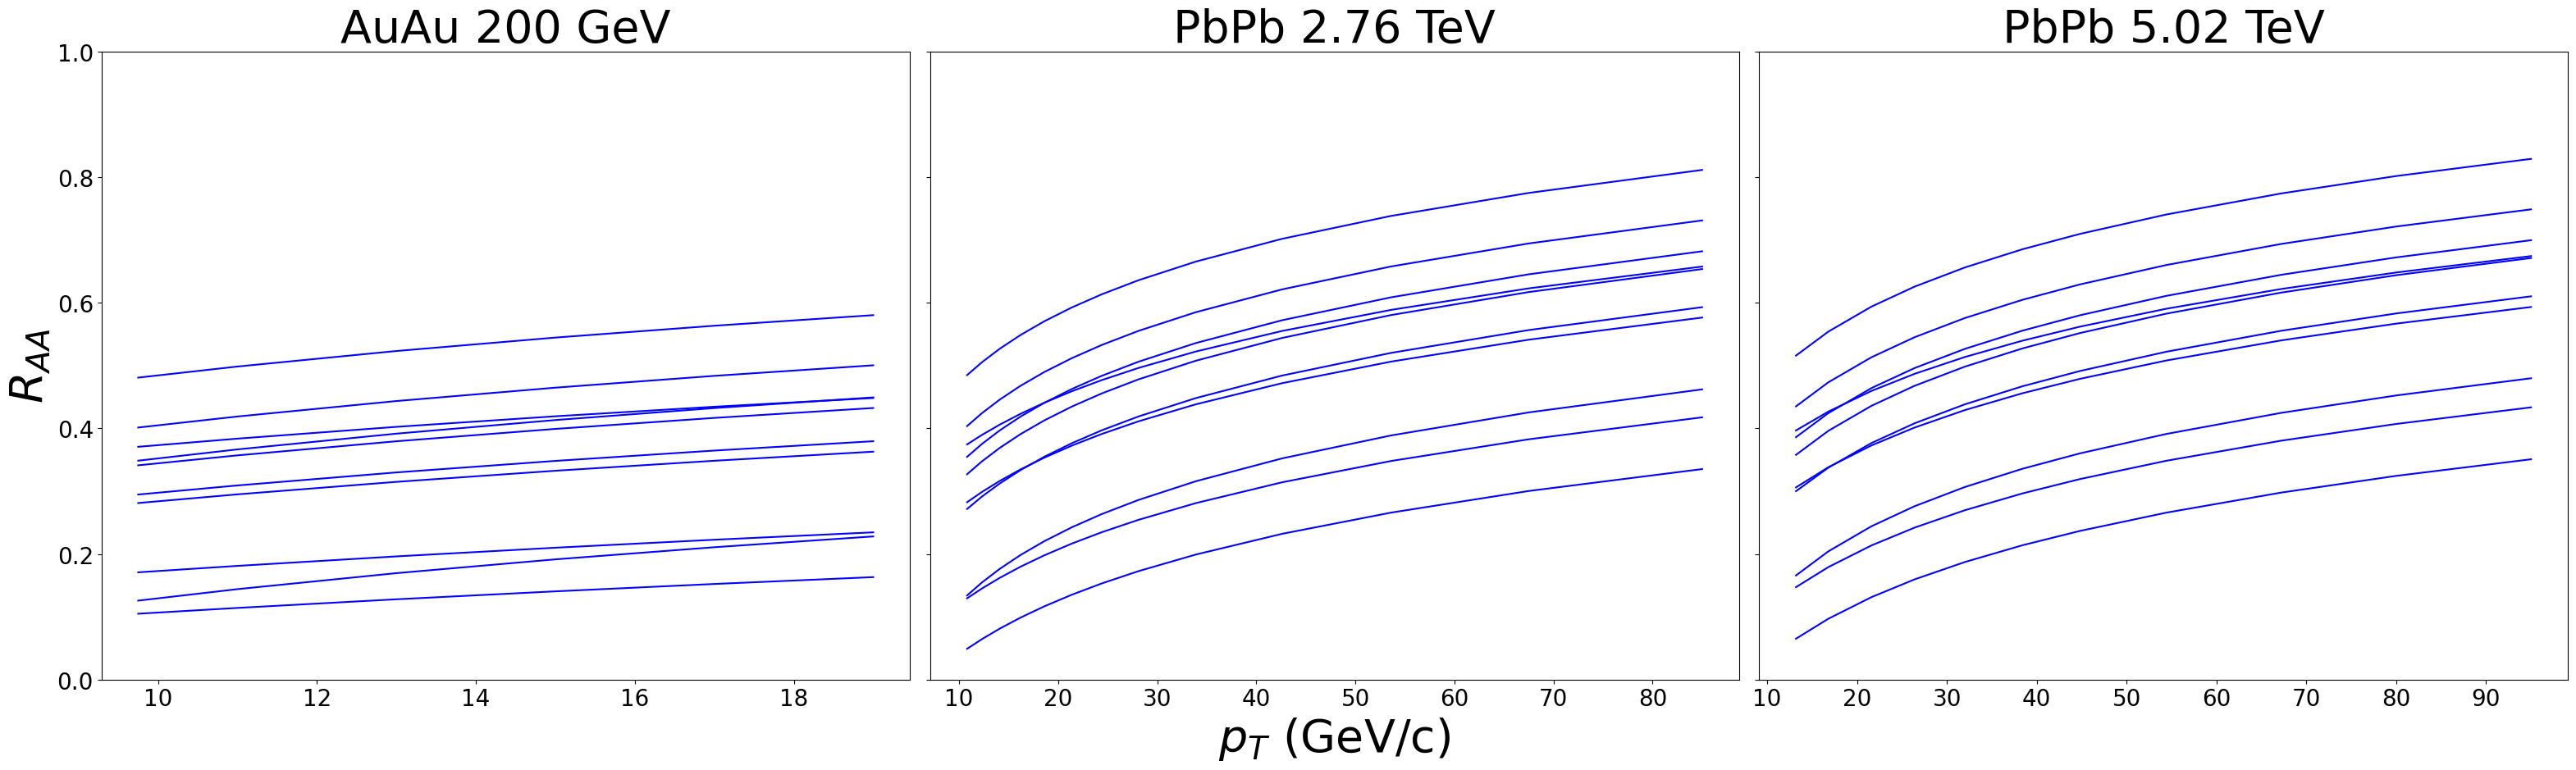

In [5]:
RAA = {}
y_train_results = {}
y_val_results = {}
total_low = {}
total_high = {}

fig, axes = plt.subplots(1, 3, figsize=(35, 10), sharey=True)

for i, system in enumerate(['AuAu200', 'PbPb2760', 'PbPb5020']):

    ax = axes[i] 
    experiment = 'PHENIX' if system == 'AuAu200' else 'ATLAS' if system == 'PbPb2760' else 'CMS' 
    coll = 'AuAu' if system == 'AuAu200' else 'PbPb' if system == 'PbPb2760' else 'PbPb'
    energy = '200 GeV' if system == 'AuAu200' else '2.76 TeV' if system == 'PbPb2760' else '5.02 TeV'
    
    cent_val = 0.05 
    sNN = 200 if 'AuAu' in system else 2760 if 'PbPb2760' in system else 5020
    pT[system] = np.array(pT[system])

    y_train = np.array([R_AA(pT[system], train_points[j, :], cent_val, sNN) for j in range(train_points.shape[0])])
    y_val = np.array([R_AA(pT[system], validation_points[j, :], cent_val, sNN) for j in range(validation_points.shape[0])])

    y_train_results[system] = y_train
    y_val_results[system] = y_val

    ax.set_title(f'{coll} {energy}', fontsize=40)
    ax.set_ylim(0, 1)
    ax.yaxis.set_tick_params(labelsize=20)
    ax.xaxis.set_tick_params(labelsize=20)

    if i == 0:  # Set ylabel only for the first subplot
        ax.set_ylabel('$R_{AA}$', fontsize=40)
        label = f'{experiment}: $0-10\\%$ Centrality'
    elif i == 1:
        ax.set_xlabel('$p_T$ (GeV/c)', fontsize=40)
        label = f'{experiment}: $0-5\\%$ Centrality'
    else:
        label = f'{experiment}: $0-10\\%$ Centrality'
   
    ax.plot(pT[system].reshape(-1,1), y_train_results[system].T, color='blue', markersize=10, label=label)

plt.tight_layout(rect=[0, 0, 0.9, 0.95])


## Parameter Space for training and validation points

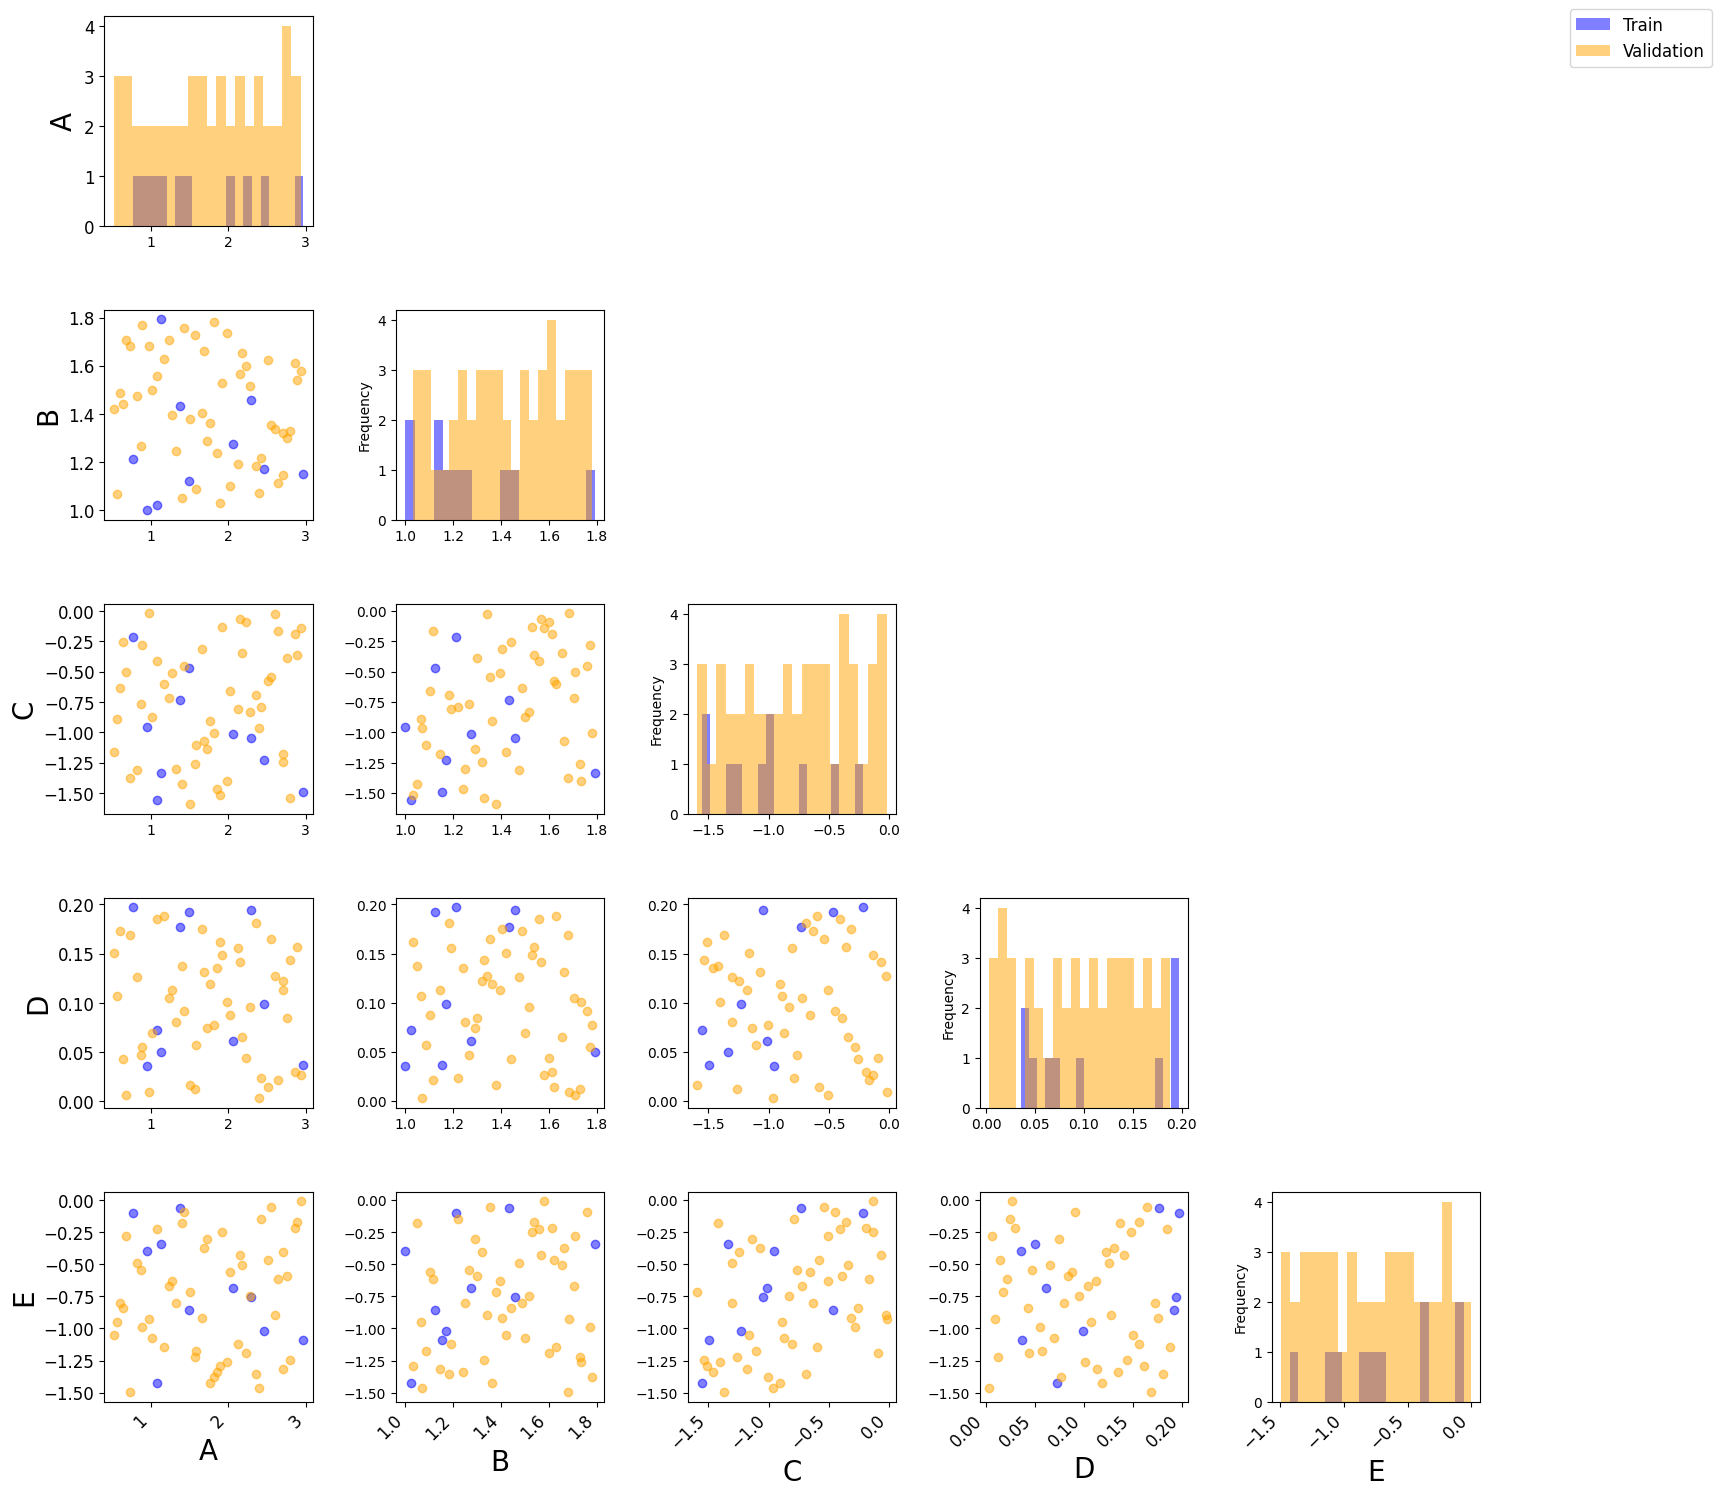

In [6]:
plots.plot_design_points(train_points, validation_points)

## Train Smooth Emulator 

In [7]:
Smooth_train_mean = {}
Smooth_train_errors = {}
Smooth_val_mean = {}
Smooth_val_errors = {}

Smooth_train_mean, Smooth_train_errors, Smooth_val_mean, Smooth_val_errors = [{} for _ in range(4)]

for system in ['AuAu200', 'PbPb2760', 'PbPb5020']:
    Smooth.fit(x=pT[system], theta=train_points, f=y_train_results[system], priors=priors, label=system, order=5, Lambda=2)
    Smooth_train_mean[system], Smooth_train_errors[system] = Smooth.predict(train_points, system)
    Smooth_val_mean[system], Smooth_val_errors[system] = Smooth.predict(validation_points, system)
    os.chdir(work_path)   


## Train AKSGP Emulator 

In [8]:
AKSGP_train_mean = {}
AKSGP_train_errors = {}
AKSGP_val_mean = {}
AKSGP_val_errors = {}

AKSGP_train_mean, AKSGP_train_errors, AKSGP_val_mean, AKSGP_val_errors = [{} for _ in range(4)]

for system in ['AuAu200', 'PbPb2760', 'PbPb5020']:
    aks = AKS_emu(X=train_points, Y_mean=y_train_results[system], Y_std=None)
    aks.fit()

    AKSGP_train_mean[system], AKSGP_train_errors[system] = aks.predict(train_points)
    AKSGP_val_mean[system], AKSGP_val_errors[system] = aks.predict(validation_points)


2024-12-19 16:45:02 - src.AKSGP - INFO - Automatic kernel selection opted. Best kernel for each output dimension will be selected from the list of kernels:
   ['Matern12', 'Matern32', 'Matern52', 'RBF']

2024-12-19 16:45:02 - src.AKSGP - INFO - Shape of training arrays: (9, 5), (9, 6), (9, 6)
2024-12-19 16:45:02 - src.AKSGP - INFO - Shape of validation arrays: (1, 5), (1, 6), (1, 6)
2024-12-19 16:45:02 - src.AKSGP - INFO - Training GPs with all available kernels...
2024-12-19 16:45:02 - src.AKSGP - INFO -   Standardizing input space...
2024-12-19 16:45:02 - src.AKSGP - INFO -   Standardizing data...
/Users/christalmartin/BAND_fellowship/BAND_example/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/christalmartin/BAND_fellowship/BAND_ex

## Train Surmise Emulator

In [9]:
Emulators = {}
Surmise_val = {}
Surmise_train = {}
    
for system in ['AuAu200', 'PbPb2760', 'PbPb5020']:
    # print(y_train_results[system].T.shape)
    Emulators[system] = emulator(x=pT[system], theta=train_points, f=y_train_results[system].T, method='indGP')

    Surmise_val[system] = Emulators[system].predict(x=pT[system], theta=validation_points).mean().T
    Surmise_train[system] = Emulators[system].predict(x=pT[system], theta=train_points).mean().T    

## Train Scikit-Learn Emulator

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels

SK_Emulators = {}
Scikit_val = {}
Scikit_train = {}

ptp = np.max(train_points) - np.min(train_points)
kernel = (1. * kernels.Matern(length_scale=ptp, length_scale_bounds=np.outer(ptp, (.1, 5))))

for system in ['AuAu200', 'PbPb2760', 'PbPb5020']:
    combined_train = []
    combined_val = []
    for train_point in train_points:
        combined_train.append(np.concatenate((pT[system], train_point)))
    for val_point in validation_points:
        combined_val.append(np.concatenate((pT[system], val_point)))
    SK_Emulators[system] = GPR(kernel=kernel, alpha=0, n_restarts_optimizer=0).fit(combined_train, y_train_results[system])
    Scikit_val[system] = SK_Emulators[system].predict(combined_val)
    Scikit_train[system] = SK_Emulators[system].predict(combined_train)

## Compare Emulators

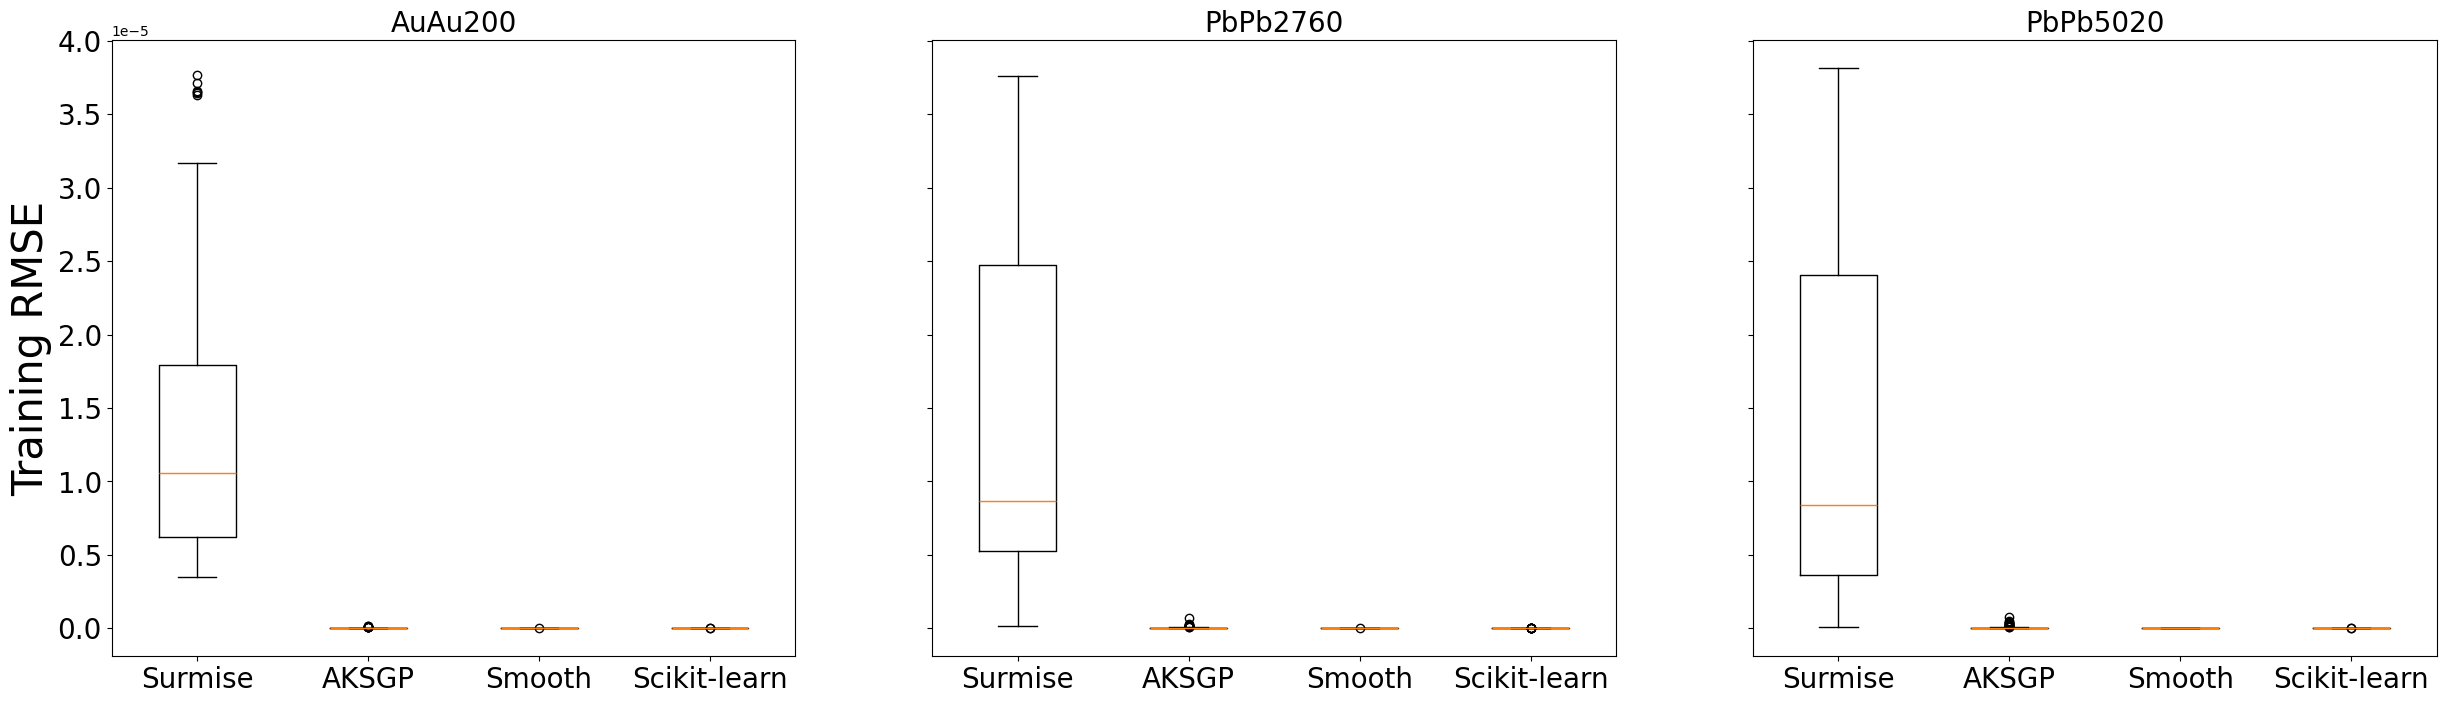

In [11]:
fig_train, axes_train = plt.subplots(1, 3, figsize=(30, 8), sharey=True) 

for i, system in enumerate(['AuAu200', 'PbPb2760', 'PbPb5020']):
    plots.plot_combined_box_rmse(
        axes_train[i],  
        y_train_results[system],  
        Surmise_train[system],
        AKSGP_train_mean[system],
        Smooth_train_mean[system],  
        Scikit_train[system], 
        label=system, 
        plot_type="Training" 
    )
axes_train[0].set_ylabel('Training RMSE', fontsize=30)
plt.show()

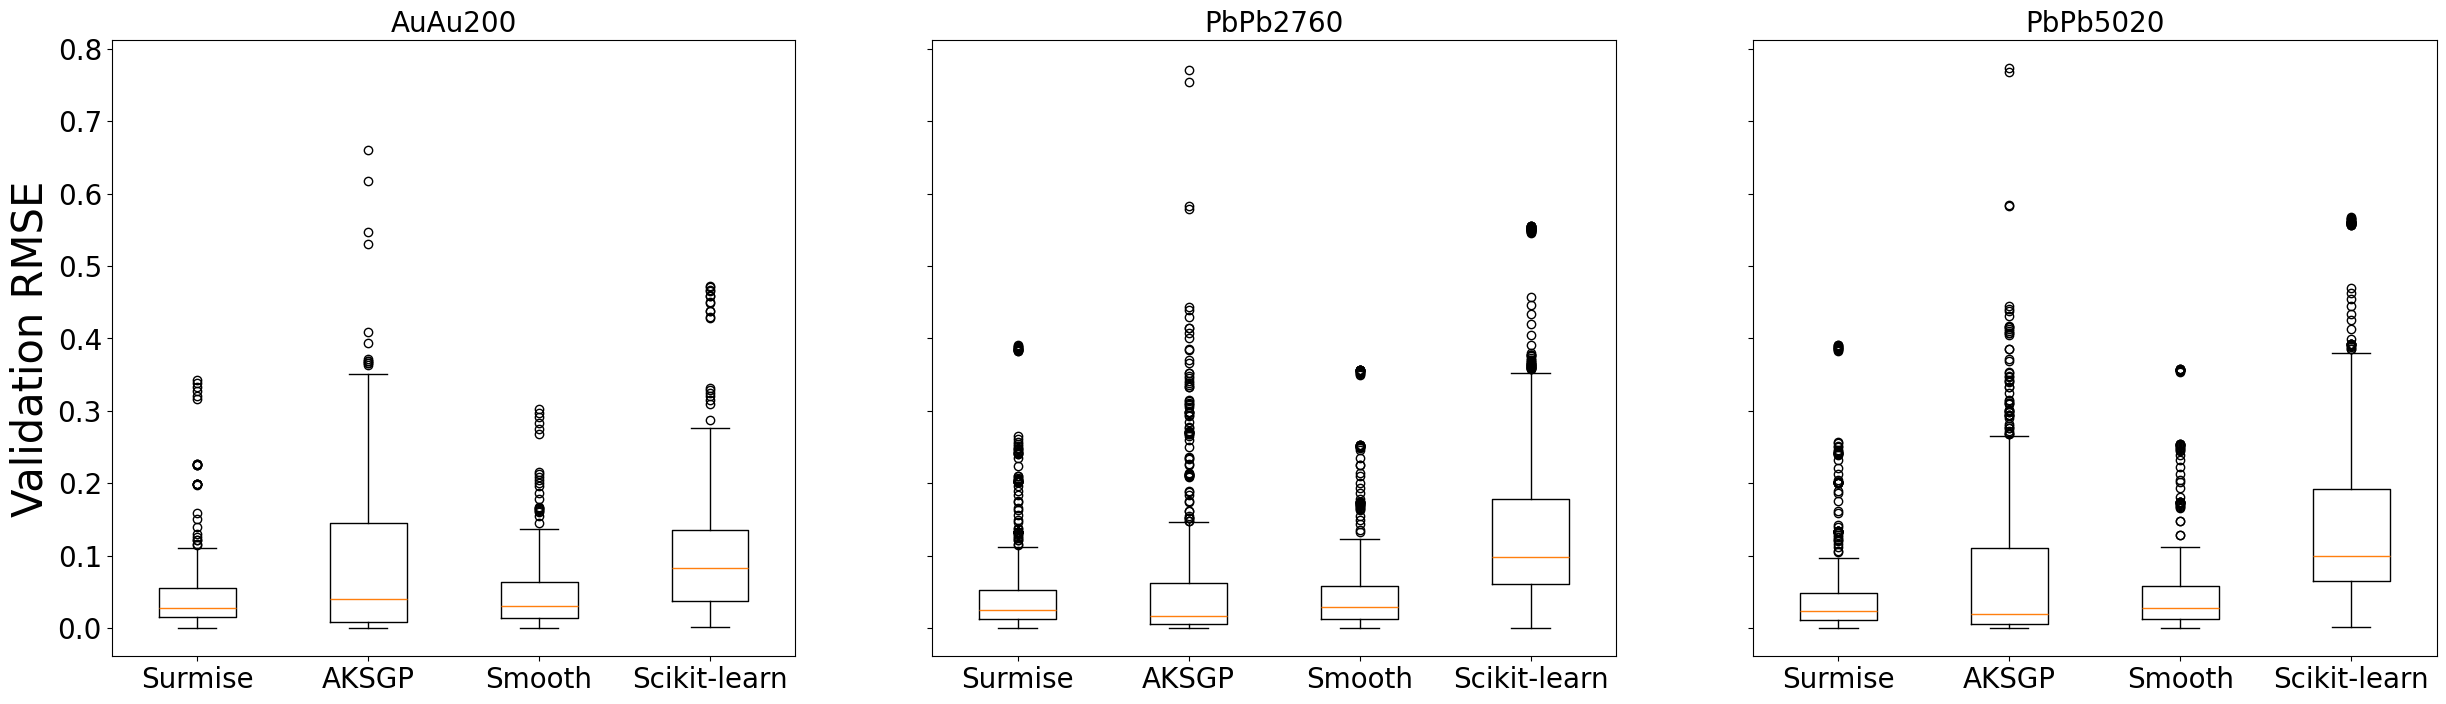

In [12]:
fig_val, axes_val = plt.subplots(1, 3, figsize=(30, 8), sharey=True) 
for i, system in enumerate(['AuAu200', 'PbPb2760', 'PbPb5020']):
    plots.plot_combined_box_rmse(
            axes_val[i],  
            y_val_results[system],  
            Surmise_val[system], 
            AKSGP_val_mean[system],
            Smooth_val_mean[system],  
            Scikit_val[system],  
            label=system, 
            plot_type="Validation" 
        )
axes_val[0].set_ylabel('Validation RMSE', fontsize=30)
plt.show()

## The sections below are for comparing emulators over different number of training points and averaging over different seeds

Set skip_cell (in the Parameter section) to True if you don't want the code to excute the code below.

In [13]:
if not skip_cell:
    rand_seed = np.random.randint(1, 100000, num_seed)
    filename = 'run_trainsize.sh'

    # Modify the lines containing SEEDS and TRAIN_SIZES
    with open(filename, 'r') as file:
        lines = file.readlines()

    for i, line in enumerate(lines):
        if 'SEEDS=(' in line:
            lines[i] = f'SEEDS=({" ".join(map(str, rand_seed))})\n'
        elif 'TRAIN_SIZES=(' in line:
            lines[i] = f'TRAIN_SIZES=({" ".join(map(str, train_range))})\n'

    # Write the modified content back to the .sh file
    with open(filename, 'w') as file:
        file.writelines(lines)

    subprocess.run(['bash', filename], check=True)

In [14]:
if dmax == False:
    filename = 'rmse_results.txt'
else:
    filename = f'rmse_results_Detmax.txt'

header = "System, Training Points, Seed, Smooth, Surmise, Scikit-learn\n"

for i, system in enumerate(['AuAu200', 'PbPb2760', 'PbPb5020']):
    rmse = {}
    smooth_rmse = np.sqrt(np.mean((Smooth_val_mean[system] - y_val_results[system]) ** 2))  
    surmise_rmse = np.sqrt(np.mean((Surmise_val[system] - y_val_results[system]) ** 2))  
    sckit_rmse = np.sqrt(np.mean((Scikit_val[system] - y_val_results[system]) ** 2))   
    rmse['Smooth'] = smooth_rmse
    rmse['Surmise'] = surmise_rmse
    rmse['Scikit-learn'] = sckit_rmse
    entry_exists = False

    # Check if the file exists and write the header if it doesn't
    if not os.path.exists(filename) or os.path.getsize(filename) == 0:
        with open(filename, 'w') as f:  
            f.write(header)

    # Check if the entry already exists in the file
    with open(filename, 'r') as f:
        for line in f:
            if f"{system}, {train_size}, {seed}" in line:
                entry_exists = True
                break  
            
    # Write to the file only if the entry doesn't already exist
    if not entry_exists and not seed == 0:
        with open(filename, 'a') as f: 
            f.write(f"{system}, {train_size}, {seed}, {rmse['Smooth']:.5f}, {rmse['Surmise']:.5f}, {rmse['Scikit-learn']:.5f}\n")
    else:
        print(f"Entry for {system} with {train_size} training points and seed {seed} already exists.")


Entry for AuAu200 with 10 training points and seed 0 already exists.
Entry for PbPb2760 with 10 training points and seed 0 already exists.
Entry for PbPb5020 with 10 training points and seed 0 already exists.


In [15]:
if not skip_cell:    
    # Initialize the result dictionaries
    results_by_system = {}
    dm_results_by_system = {}

    # Function to process a file and store RMSE results
    def process_file(filename, results_dict):
        with open(filename, 'r') as f:
            next(f)  # Skip header
            for line in f:
                parts = line.strip().split(', ')
                system_info, training_points, seed = parts[0], int(parts[1]), int(parts[2])
                if training_points > 100:
                    continue
                rmse_values = {
                    'Smooth': float(parts[3]),
                    'Surmise': float(parts[4]),
                    'Scikit-learn': float(parts[5])
                }
                results_dict.setdefault(system_info, {}).setdefault(training_points, {'Smooth': [], 'Surmise': [], 'Scikit-learn': []})
                for key, value in rmse_values.items():
                    results_dict[system_info][training_points][key].append(value)

    # Process both RMSE files
    process_file('rmse_results.txt', results_by_system)
    process_file('rmse_results_Detmax.txt', dm_results_by_system)

    # Function to calculate mean and std RMSE values across all seeds
    def calculate_stats(results_dict):
        mean_results = {}
        std_results = {}
        for system, training_data in results_dict.items():
            mean_results[system] = {}
            std_results[system] = {}
            for training_points, rmse_data in training_data.items():
                mean_results[system][training_points] = {k: np.mean(v) for k, v in rmse_data.items()}
                std_results[system][training_points] = {k: np.std(v) for k, v in rmse_data.items()}
        return mean_results, std_results

    # Calculate mean and std for both sets of results
    mean_results_by_system, std_results_by_system = calculate_stats(results_by_system)
    dm_mean_results_by_system, dm_std_results_by_system = calculate_stats(dm_results_by_system)

    # Define linestyles, markers, and colors
    colors = {'Surmise': 'black', 'Smooth': 'red', 'Scikit-learn': 'blue'}

    # Create figure and axes
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    # Collect handles and labels for the legend
    handles, labels = [], []

    # Iterate over the systems to plot the data
    for i, system in enumerate(mean_results_by_system.keys()):
        ax = axs[i]
        data = mean_results_by_system[system]
        dm_data = dm_mean_results_by_system[system]
        training_points = sorted(data.keys())

        # Plot for each method (Surmise, Smooth, Scikit-learn)
        for method in ['Surmise', 'Smooth', 'Scikit-learn']:

            means = [data[tp][method] for tp in training_points]
            stds = [std_results_by_system[system][tp][method] for tp in training_points]

            dm_means = [dm_data[tp][method] for tp in training_points]
            dm_stds = [dm_std_results_by_system[system][tp][method] for tp in training_points]

            label1 = f'{method} with DETMAX'
            label2 = method

            # Plot DETMAX results
            line1, = ax.plot(training_points, dm_means, label=label1, color=colors[method], marker='o', linestyle='--', linewidth=2)
            ax.fill_between(training_points, np.array(dm_means) - np.array(dm_stds), np.array(dm_means) + np.array(dm_stds), color=colors[method], alpha=0.2)

            # Plot regular results
            line2, = ax.plot(training_points, means, label=label2, color=colors[method], marker='o', linestyle='-', linewidth=2)
            ax.fill_between(training_points, np.array(means) - np.array(stds), np.array(means) + np.array(stds), color=colors[method], alpha=0.2)

            if i == 0:
                handles.extend([line1, line2])
                labels.extend([label1, label2])

        ax.set_title(system, fontsize=20)
        ax.yaxis.set_tick_params(labelsize=20)
        ax.xaxis.set_tick_params(labelsize=20)
        if i == 0:
            ax.set_ylabel('Mean RMSE', fontsize=24)
        elif i == 1:
            ax.set_xlabel('# of Training Points', fontsize=24)

    # Create a single figure-level legend
    fig.legend(handles, labels, fontsize=14, loc='upper right', bbox_to_anchor=(.30, .85))
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
